# Analysis of HSPCs data using scTIE

This tutorial demonstrates data integration and inference analysis using scTIE via a HSPCs 10x multiome data provided in Kaggle and NIPS2022 competition "Open Problems - Multimodal Single-Cell Integration"


The data is downloaded from website:
https://www.kaggle.com/competitions/open-problems-multimodal/overview

For illustration purpose, here we use a subset of the data, with roughly the same size of our in-house mouse ESC data. 



In [186]:
import h5py
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
random.seed(1)

## Running scTIE

**Calculating initial growth rate**

The optimal transport calculation in scTIE requires a list of initial growth rate files as input. This can be generated via `calculate_growth_rate.py` with modification of the data directory paths, which will then generate a `data/NIPS/day<d>_growth_gs_init.npy` file for each day d.

**Modifying `config.py`**

The multiome dataset has 18152 genes and 61794 peaks that are expressed in more than 2% of cells. The data are collected on Day 2, 3, 4 and 7. The input paths also needed to be edited accordingly. Here are the settings for integration of HSPCs data we set in `config.py`:

```
self.rna_size = 18152
self.atac_size = 61794
self.growth_estimates = [f"data/NIPS/day{day}_growth_gs_init.npy" for day in self.days]
self.rna_paths = [f"data/NIPS/nips_day{d}_rna.npz" for d in self.days]
self.atac_paths = [f"data/NIPS/nips_day{d}_atac.npz" for d in self.days]
```


### Part 1: Temporal multimodal data integration


After modifying `config.py`, we are ready to run scTIE data integration in terminal with the following codes, which will run the data integration with the defualt settings.

```
# Stage 1
python3 main.py --modalities rna  \
  --DB "nips" \
  --days 2 3 4 7 \
  --output_dir "output/NIPS" \
  --ncores 1
 
# Stage 2
python3 main.py --modalities rna atac \
  --DB "nips" \
  --days 2 3 4 7 \
  --ckpt "output/NIPS/checkpoint_rna_nips_mse_d2-3-4-7_ot0.1_common1.0_otepoch10_hidden1000_e500.pth.tar" \
  --output_dir "output/NIPS" \
  --ncores 1
```

This together takes ~5 hours using 1 thread for PyTorch.


### Visualisation

The output files of scTIE are stored in `<output_dir>/<DB>/<exp_name>/` folder. The common embeddings are stored in `common_embeddings_<i>_<epoch>.npy` files, where `i` refers to the day ID (0, 1, 2, 3, ...) and `epoch` refers to the saved epoch. Dimension reduction methods like tSNE and UMAP can be applied on the embeddings files for visualisations.

In [187]:
days = [2, 3, 4, 7]
output_dir = "../output/NIPS/rna-atac_nips_mse_d2-3-4-7_ot0.1_common1.0_otepoch10_hidden1000_rna-pretrain/"
epoch = 500
common_embeddings = []
for d in range(len(days)):
    print(d)
    file_name = f"{output_dir}/common_embeddings_{d}_{epoch}.npy"
    common_embeddings.append(np.load(file_name))
common_embeddings =  np.concatenate(common_embeddings)
print(common_embeddings.shape)

0
1
2
3
(10594, 64)


In [188]:
umap_results = umap.UMAP(min_dist = 0.3).fit_transform(common_embeddings)
umap_results.shape

(10594, 2)

<AxesSubplot: xlabel='UMAP1', ylabel='UMAP2'>

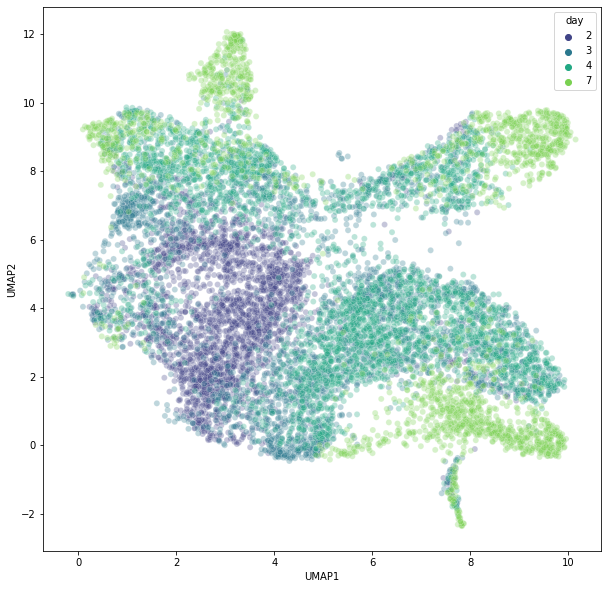

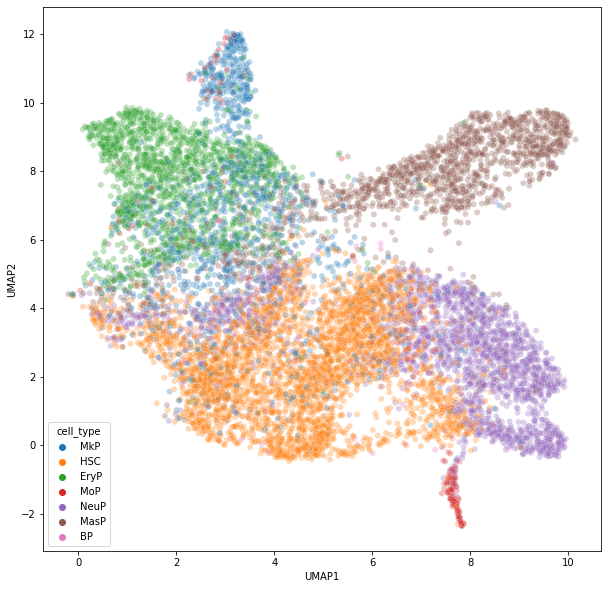

In [189]:
df = pd.read_csv("../data/NIPS/meta_data.csv")
df['UMAP1'] = umap_results[:,0]
df['UMAP2'] = umap_results[:,1]
plt.figure(figsize=(10,10))
sns.scatterplot(
    x = "UMAP1", y = "UMAP2",
    hue = "day",
    palette = sns.color_palette("viridis", 4),
    data = df,
    legend = "full",
    alpha = 0.3
)
plt.figure(figsize=(10,10))
sns.scatterplot(
    x = "UMAP1", y = "UMAP2",
    hue = "cell_type",
    palette = sns.color_palette("tab10", 7),
    data = df,
    legend = "full",
    alpha = 0.3
)

### Part 2: Embedding gradient backpropagation

Next, we can interpret the embedding space projected by scTIE by deconvoluting the patent representation via backpropogating the gradient of each dimension in the embedding layer with respect fo the gene and peak input. 

The following codes ran in terminal will output the average embedding gradient for cells for all the cells on Day 2, 3, 4 & 7, saved as two `.npy` files `jacob_rna_cellset_all_average.npy` and `jacob_atac_cellset_all_average.npy` in `output/NIPS/emb_grad_all/` folder.


```
python3 embedding_grad_all.py \
--DB "nips" \
--cell_set_name "all" \
--average \
--pretrained_name "rna-atac_nips_mse_d2-3-4-7_ot0.1_common1.0_otepoch10_hidden1000_rna-pretrain_e500" \
--pretrained_checkpoints_dir "output/NIPS/" \
--save_dir "output/NIPS/emb_grad_all/" \
--days 2 3 4 7
```
This takes ~1 hour using 1 thread for PyTorch.

### Part 3: Cell transition probability backpropagation



Finally, we will select the features that are preditive to cell transition probability using `infer_deconv.py`. Firstly, we need to require the following extra input files apart from the output in the previous steps.

1. A `.csv` file indicates the indices of peaks to be removed (Optional, but suggested).
2. A few `.csv` files indicate the **Selection of three groups of cells ($G_0, G_1, G_2$)**

+ A group of cells from earlier days ($G_0$): This is indicated by `day{d1}_{day1_cluster}.csv`, `d in {day1}`, where the each `.csv` file should indicate the indices of cluster `day1_cluster` on day `d1`.
+ Two groups of cells from later days ($G_1, G_2$): This is indicated by `day{d2}_{day2_cluster}_from_day{d1}_{day1_cluster}.csv`, `d in {day1}`, where the each `.csv` file should indicate the indices of descendants of day `d1` `day1_cluster` that are cluster `day2_cluster` on day `d2`. `day2_cluster` should contain two groups for contrast.


For example, if we would like to look at what are the features that are associated with the transition probability of HSC on Day 2, 3 to NeuP on Day 3, 4, 7, compared to all other descendants, we need to set the parameters as the following:
```
--day1 2 3 \
--day2 3 4 7 \
--day1_cluster "HSC" \
--day2_clusters "NeuP" "NeuPOthers" \
```
and it requires the following `.csv` file in `<input_dir>`:

+ $G_0$: `day2_HSC.csv`, `day3_HSC.csv`
+ $G_1$: `day3_NeuP_from_day2_HSC.csv`, `day4_NeuP_from_day2_HSC.csv`, `day7_NeuP_from_day2_HSC.csv`,  `day4_NeuP_from_day3_HSC.csv`, `day7_NeuP_from_day3_HSC.csv`
+ $G_2$: `day3_NeuPOthers_from_day2_HSC.csv`, `day4_NeuPOthers_from_day2_HSC.csv`, `day7_NeuPOthers_from_day2_HSC.csv`,  `day4_NeuPOthers_from_day3_HSC.csv`, `day7_NeuPOthers_from_day3_HSC.csv`



In [190]:
# The following codes show how to generate the day{d1}_{day1_cluster}.csv files
newpath = "../data/NIPS/cluster_idx"
if not os.path.exists(newpath):
    os.makedirs(newpath)
    
for d in set(df["day"]):
    for cluster in set(df["cell_type"]):
        df_subset = df.loc[(df["day"] == d)].reset_index(drop=True)
        ind = df_subset[df_subset["cell_type"] == cluster].index
        pd.DataFrame(ind).to_csv(f"../data/NIPS/cluster_idx/day{d}_{cluster}.csv", index = False)




Then we can run the following codes in terminal look at what are the features that are associated with the transition probability of HSC on Day 2, 3 to NeuP on Day 3, 4, 7, compared to all other descendants:

```
python3 infer_deconv.py \
--DB "nips" \
--day1 2 3 \
--day2 3 4 7 \
--day1_cluster "HSC" \
--day2_clusters "NeuP" "NeuPOthers" \
--input_dir data/NIPS/cluster_idx/ \
--atac_l1_weight 100 \
--rna_l1_weight 100 \
--output_dir output/NIPS/grad_results/ \
--filter_peaks data/NIPS/cluster_idx/remove_peaks_by_accessibility_idx_prop_1.1.csv \
--pretrained_results_dir output/NIPS/ \
--pretrained_checkpoints_dir output/NIPS/ \
--pretrained_name "rna-atac_nips_mse_d2-3-4-7_ot0.1_common1.0_otepoch10_hidden1000_rna-pretrain" \
--seed 1
```

This takes around ~10 min using 1 thread in PyTorch.

